
# WiDS CAMBRIGE DATATHON WORKSHOP
## February 21st, 2019
### Instructors: Anastasiya Belyaeva (MIT), Weiwei Pan (Harvard)

<img src="https://drive.google.com/uc?export=view&id=1jTMwxRlcUKSE57wnAE4ZT5Z_C8wL1vBC" style='height:300px;' align="left">

## SPONSORS:

<img src="https://drive.google.com/uc?export=view&id=1quSTLcH9v-_JxMgHRLxCZnlEfPXDx_lP" style="height:60px;" align="left"><img src="https://drive.google.com/uc?export=view&id=1as5kaUFRlDkvVLVPuf7WeHg8FkbHqIZF" style="height:60px;" align="left"> <img src="https://drive.google.com/uc?export=view&id=1l4iYE3dPwszuz8Bg8ZVNqt8n3PEGwvAP" style="height:60px;" align="left">

In [73]:
# Includes the necessary libraries
import numpy as np
import matplotlib.pylab as plt 
import os

from keras import backend as K
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Conv2D, MaxPooling2D
from keras.callbacks import Callback, ModelCheckpoint, History 
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.optimizers import SGD, Adam

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_circles, fetch_olivetti_faces
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import confusion_matrix, roc_auc_score

%matplotlib inline

random_state = 0
random = np.random.RandomState(random_state)

# I. Classification with Non-linear Decision Boundaries



## Classification with Linear Boundaries
In **logistic regression**, we model the probability of an input $\mathbf{x}$ being labeled '1' as a function of its distance from the hyperplane parametrized by $\mathbf{w}$

<img src="./fig/img30.png" style='height:200px;'>

That is, we model $p(y=1 | \mathbf{w}, \mathbf{x}) = \sigma(\mathbf{w}^\top \mathbf{x})$. Where $\mathbf{w}^\top \mathbf{x}=0$ is the equation of the decision boundary.

## How would you parametrize a ellipitical decision boundary?

The probability of a point being labeled '1' depends on a quadratic function of the input:
$$
p(y=1 | \mathbf{W}, \mathbf{x}) = \sigma\left(w_1x^2_1 + w_2x^2_2 + w_3\right)
$$

In [232]:
# generate a toy classification data set with non-linear decision boundary
X, Y = make_circles(noise=0.1, random_state=random_state, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

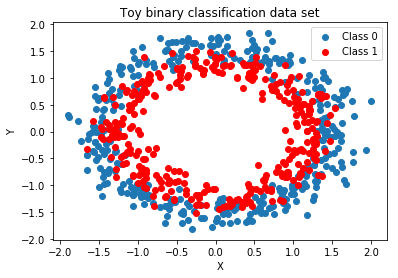

In [233]:
# scatter plot the data, color each class differently
fig, ax = plt.subplots()
ax.scatter(X_train[Y_train==0, 0], X_train[Y_train==0, 1], label='Class 0')
ax.scatter(X_train[Y_train==1, 0], X_train[Y_train==1, 1], color='r', label='Class 1')
ax.legend(loc='upper right')
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set')
plt.show()

## How would you parametrize a complex decision boundary?

The probability of a point being labeled '1' depends on a complex non-linear function, $g$, of the input
$$
p(y=1 | \mathbf{W}, \mathbf{x}) = \sigma(g(\mathbf{W}, \mathbf{x}))
$$

In [218]:
# generate a toy classification data set with non-linear decision boundary
X, Y = make_moons(noise=0.5, random_state=random_state, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.3)

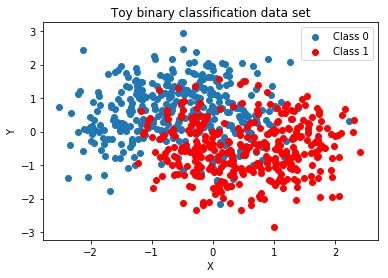

In [219]:
# scatter plot the data, color each class differently
fig, ax = plt.subplots()
ax.scatter(X_train[Y_train==0, 0], X_train[Y_train==0, 1], label='Class 0')
ax.scatter(X_train[Y_train==1, 0], X_train[Y_train==1, 1], color='r', label='Class 1')
ax.legend(loc='upper right')
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set')
plt.show()

## Approximating Arbitrarily Complex Decision Boundaries

Given an exact parametrization, we could learn the functional form, $g$, of the decision boundary directly. 

However, assuming an exact form for $g$ is restrictive. 

Rather, we can build increasingly good approximations, $\widehat{g}$, of $g$ by composing simple functions. 

## What is a Neural Network?

**Goal:** build a good approximation $\widehat{g}$ of a complex function $g$ by composing simple functions.

For example, let the following picture represents $f\left(\sum_{i}w_ix_i\right)$, where $f$ is a non-linear transform:

<img src="./fig/img19.png" style='height:200px;'>


## Neural Networks as Function Approximators

Then we can define the approximation $\widehat{g}$ with a graphical schema representing a complex series of compositions and sums of the form, $f\left(\sum_{i}w_ix_i\right)$

<img src="./fig/img20.png" style='height:300px;'>

This is a ***neural network***. We denote the weights of the neural network collectively by $\mathbf{W}$.

## A Flexible Framework for Function Approximation


<img src="./fig/NNchart1.png" style='height:500px;'>


## Neural Network for Classification

**Task:** given a *training dataset* of $N$ labeled images
$$
\mathbf{X} \in \mathbb{R}^{N \times V},\; \mathbf{y} \in \{0, 1\}^{N}
$$
find values for the parameters, $\mathbf{W}$, of the NN that maximizes a *model fitness metric*. 


For example, we can again choose fitness to be the likelihood on the training data
$$
\mathbf{W}_{\text{MLE}} = \underset{\mathbf{w}}{\mathrm{argmax}}\; \mathcal{L}(\mathbf{W}, \mathbf{X}, \mathbf{y}) = \underset{\mathbf{w}}{\mathrm{argmax}}\; \prod_{n} p(y_n | \widehat{g}(\mathbf{W}, \mathbf{X}))
$$
A method of "gradient descent" called ***back-propagation*** can be used.

## Building a Neural Network for Classificatinon in Keras

Keras is a `python` library that provides intuitive api's for build neural networks quickly. 

In [205]:
def create_model(input_dim, optimizer):
    # create sequential multi-layer perceptron
    model = Sequential()
    #layer 0
    model.add(Dense(100, input_dim=input_dim, activation='tanh', 
                    kernel_initializer='random_uniform',
                    bias_initializer='zeros')) 
    #layer 1
    model.add(Dense(100, activation='tanh', 
                    kernel_initializer='random_uniform',
                    bias_initializer='zeros')) 
    #layer 2
    model.add(Dense(2, activation='tanh', 
                    kernel_initializer='random_uniform',
                    bias_initializer='zeros'))
    #binary classification, one output
    model.add(Dense(1, activation='sigmoid', 
                    kernel_initializer='random_uniform',
                    bias_initializer='zeros')) 

    # configure the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## BackProp: An Intuition
The intuition behind various flavours of gradient descent is as follows:

<img src="./fig/grad.pdf" style='height:400px;'>

## Gradient Descent: the Algorithm
1. start at random place: $W_0\leftarrow \textbf{random}$

2. until (stopping condition satisfied):

  a. compute gradient: 
     gradient = $\nabla$ loss\_function($W_{t}$)

  b. take a step in the negative gradient direction: 
     $W_{t+1} \leftarrow W_{t}$ - eta * gradient

Here *eta* is called the ***learning rate***.

## Training a Neural Network in Keras

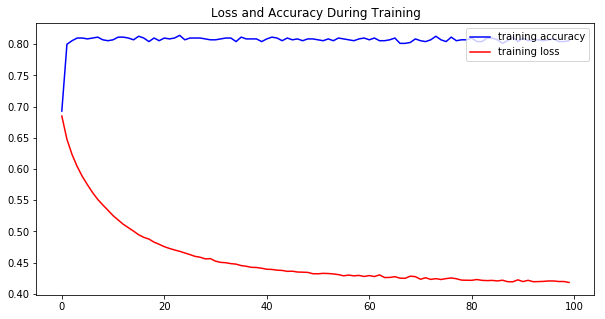

In [195]:
input_dim = X_train.shape[1]
model = create_model(input_dim, 'Adam')
history = model.fit(X_train, Y_train, batch_size=20, shuffle=True, epochs=100, verbose=0)

# Plot the loss function and the evaluation metric over the course of training
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.array(history.history['acc']), color='blue', label='training accuracy')
ax.plot(np.array(history.history['loss']), color='red', label='training loss')
ax.set_title('Loss and Accuracy During Training')
ax.legend(loc='upper right')
plt.show()

## Evaluating Your NN Classifier

In [196]:
# Evaluate the training and testing performance of your model 
# Note: you should check both the loss function and your evaluation metric
score = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1], '\n\n')

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train loss: 0.4160079543931144
Train accuracy: 0.807142858164651 


Test loss: 0.4534423303604126
Test accuracy: 0.7933333333333333


In [197]:
# get the class probabilities predicted by our MLP on the training set
Y_train_pred = model.predict(X_train)
Y_train_pred = Y_train_pred.reshape((Y_train_pred.shape[0], ))
# get the activations for the last hidden layer in the network
last_hidden_layer = -2
latent_representation = K.function([model.input, K.learning_phase()], [model.layers[last_hidden_layer].output])
activations = latent_representation([X_train, 1.])[0]

## What exactly does a neural network classifier learn?

If we visualize the last layer of the network, we see that the network has transformed the data, many times, so that it is now roughly linearly separable. 

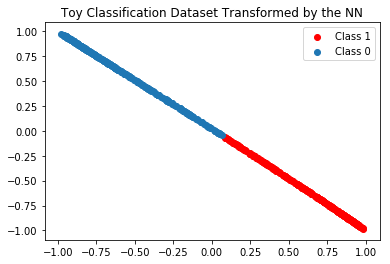

In [198]:
# plot the latent representation of our training data at the first hidden layer
fig, ax = plt.subplots()
ax.scatter(activations[Y_train_pred >= 0.5, 0], activations[Y_train_pred >= 0.5, 1], color='r', label='Class 1')
ax.scatter(activations[Y_train_pred < 0.5, 0], activations[Y_train_pred < 0.5, 1], label='Class 0')
ax.set_title('Toy Classification Dataset Transformed by the NN')
ax.legend()
plt.show()

## Expressive Models Can Be Hard to Train

As you have no doubt noticed, your learning algorithm for fitting the MLP's do not always end up with the same solution. Stochasticity is introduced in the learning process in two places:

1. the optimization is potentially not exact (we use stochastic gradients)
2. the objective is generally non-convex (i.e. there are possibly many 'pretty good' solutions and our algorithms tend to get stuck in them rather than seek out 'the absolute best' solutison) and so the solution you find will depend on where you initialize the optimization (i.e. check your initialization for the weights).

## Training Your NN: Optimization Choices Matter
<img src="./fig/stepsize.jpg" style='height:400px;'>

## Optimization with Adam

In [213]:
lrs = [1e2, 1e0, 1e-2, 1e-4, 1e-5, 1e-6] 

histories = []
for lr in lrs:
    print('learning rate', lr)
    model = create_model(input_dim, Adam(lr=lr))
    histories.append(model.fit(X_train, Y_train, batch_size=20, shuffle=True, epochs=100, verbose=0))

learning rate 100.0
learning rate 1.0
learning rate 0.01
learning rate 0.0001
learning rate 1e-05
learning rate 1e-06


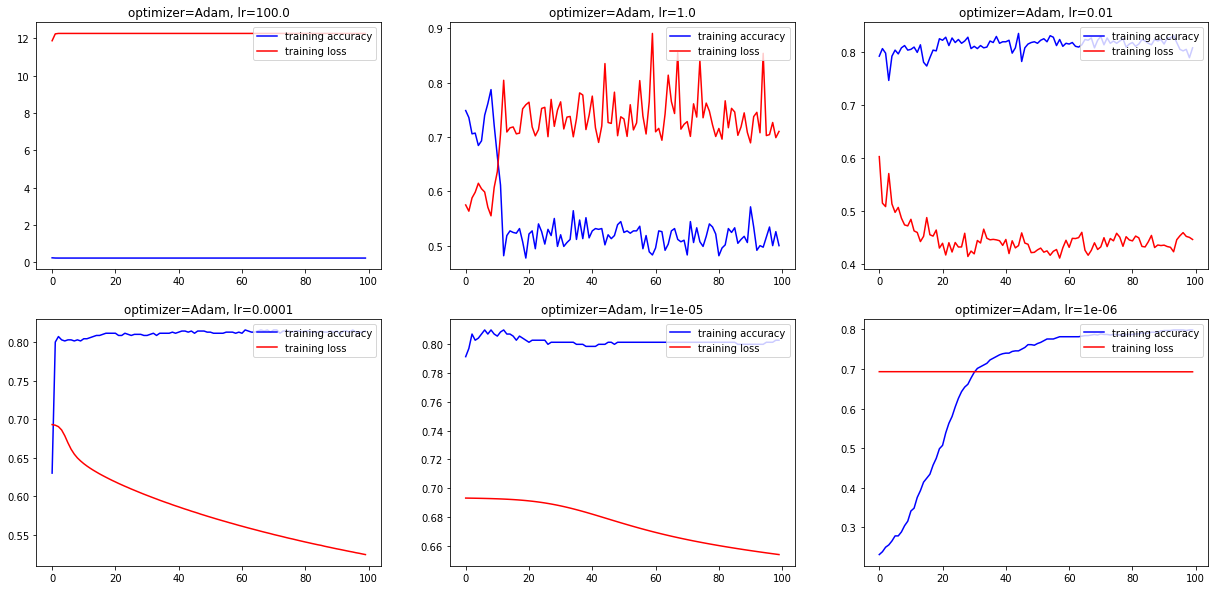

In [214]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
for i in range(len(lrs)):
    row = i // 3
    col = i % 3
    ax[row, col].plot(np.array(histories[i].history['acc']), color='blue', label='training accuracy')
    ax[row, col].plot(np.array(histories[i].history['loss']), color='red', label='training loss')
    ax[row, col].set_title('optimizer={}, lr={}'.format('Adam', lrs[i]))
    ax[row, col].legend(loc='upper right')
plt.show()

## Optimization with SGD

In [221]:
lrs = [1e1, 5e0, 1e0, 5e-1, 1e-1, 1e-2] 

histories = []
for lr in lrs:
    print('learning rate', lr)
    model = create_model(input_dim, SGD(lr=lr))
    histories.append(model.fit(X_train, Y_train, batch_size=20, shuffle=True, epochs=100, verbose=0))

learning rate 10.0
learning rate 5.0
learning rate 1.0
learning rate 0.5
learning rate 0.1
learning rate 0.01


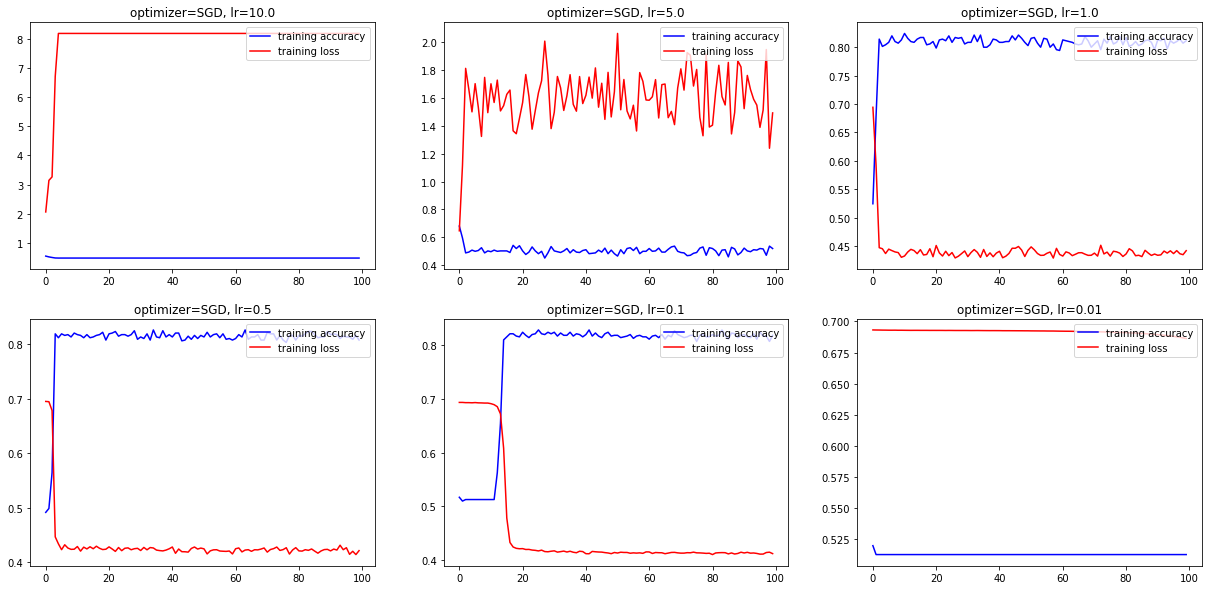

In [222]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
for i in range(len(lrs)):
    row = i // 3
    col = i % 3
    ax[row, col].plot(np.array(histories[i].history['acc']), color='blue', label='training accuracy')
    ax[row, col].plot(np.array(histories[i].history['loss']), color='red', label='training loss')
    ax[row, col].set_title('optimizer={}, lr={}'.format('SGD', lrs[i]))
    ax[row, col].legend(loc='upper right')
plt.show()

## Optimization with SGD and Momentum

In [227]:
momenta = [9e-1, 8e-1, 7e-1, 4e-1, 1e-1, 1e-2] 
epochs = 100
decay_rate = 0.1 / epochs
histories = []
for momentum in momenta:
    print('momentum', momentum)
    model = create_model(input_dim, SGD(lr=1., momentum=momentum, decay=decay_rate, nesterov=False))
    histories.append(model.fit(X_train, Y_train, batch_size=20, shuffle=True, epochs=epochs, verbose=0))

momentum 0.9
momentum 0.8
momentum 0.7
momentum 0.4
momentum 0.1
momentum 0.01


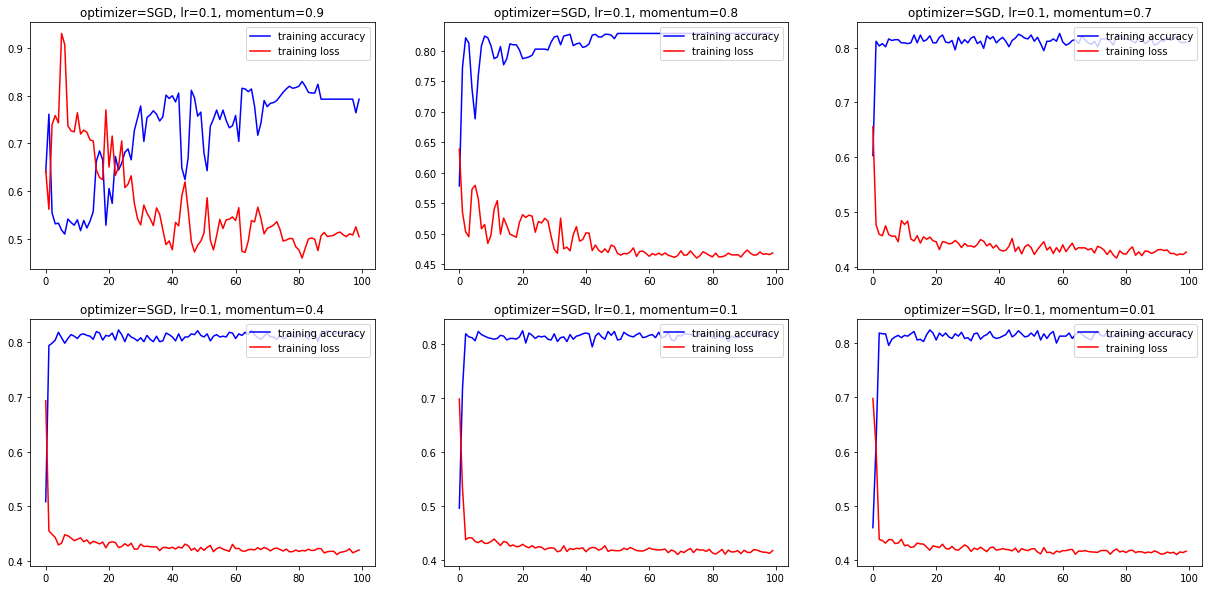

In [229]:
fig, ax = plt.subplots(2, 3, figsize=(21, 10))
for i in range(len(lrs)):
    row = i // 3
    col = i % 3
    ax[row, col].plot(np.array(histories[i].history['acc']), color='blue', label='training accuracy')
    ax[row, col].plot(np.array(histories[i].history['loss']), color='red', label='training loss')
    ax[row, col].set_title('optimizer={}, lr=0.1, momentum={}'.format('SGD', momenta[i]))
    ax[row, col].legend(loc='upper right')
plt.show()

# II. Classification with Image Data

## Working with Image Data is Challenging

In applications involving images, the first task is often to parse an image into a set of 'features' that are relevant for the task at hand. That is, we prefer not to work with images as a set of pixels.

**Question:** Can you think of why?

Traditionally, the set of relevant features to extract from raw images need to be defined before hand using domain expertise and then must be 'engineered' (computed) from the images represented as pixels. 

**Example:** for training a model to distinguish a night scene from a day scene, one might want to compare the color histograms of two images. 

The problem with the approach of feature engineering is that, a priori, it can be difficult to know what type of features best facilitate the performance of a given task, furthermore, the features engineered to optimize one task may not generalize to help accomplish another.

## Feature Extraction with Neural Networks

**Goal:** find a way to represent images as a set of "features".

Formally, a ***feature***, $F$, is an image represented as an array 
$$
F \in \mathbb{R}^{\text{width}_F\,\times\,\text{height}_F}.
$$

We want to learn a function $h$ mapping an image $X \in \mathbb{R}^{\text{width}\,\times\,\text{height}}$ to a set of $K$ features
$$
[F_1, F_2, \ldots, F_K] \in \mathbb{R}^{\sum_{k=1}^K \text{width}_{F_k}\,\times\,\text{height}_{F_k}}
$$

That is we want to learn a neural network, called a **convolutional neural network**, to approximate such a function $h$.

## Convolutional Layers
A convolutional neural network typically consists of feature extracting layers and condensing layers.

The feature extracting layers are called **convolutional layers**, each node in these layers uses a small fixed set of weights to transform the image in the following way:

<img src="./fig/convolution_layer.gif" style="width: 500px;" align="center"/>

This set of fixed weights for each node in the convolutional layer is often called a ***filter*** or a ***kernel***.

## Connections to Classical Image Processing
The term "filter" comes from image processing where one has standard ways to transforms raw images:
<img src="./fig/filter.png" style="width: 300px;" align="center"/>

## Pooling Layers

Often in CNN's we include a **pooling layer** after a convolutional layer. In a pooling layer, we 'condense' small regions in the convolved image:

<img src="./fig/pool_layer.gif" style="width: 600px;" align="center"/>

## Feature Extraction for Classification

We know that we want to learn the weights of a CNN for feature extraction, but what should our training objective be?

**Goal:** We should learn to extract features that best helps us to perform our downstream task (classification).

**Idea:** We train a CNN for feature extraction and a model (e.g. MLP, decision tree, logistic regression) for classification, *simultaneously* and *end-to-end*.

<img src="./fig/cnn.png" style="width: 800px;" align="center"/>

## Task: Classify Facial Images

In [91]:
# image shape
image_shape = (64, 64)

# load faces data
faces_dataset = fetch_olivetti_faces(shuffle=True, random_state=random_state)
faces = faces_dataset.data
labels = faces_dataset.target
n_samples, n_features = faces.shape

# take images from only two individuals
X_flat = faces[(labels == 0) | (labels == 1 )]
X = X_flat.reshape((-1, 64, 64, 1))
Y = labels[(labels == 0) | (labels == 1)]

# function to visualize images
def plot_face(ax, img, image_shape):
    vmax = max(img.max(), -img.min())
    ax.imshow(img.reshape(image_shape), cmap=plt.cm.gray,
              interpolation='nearest',
              vmin=-vmax, vmax=vmax)
    return ax

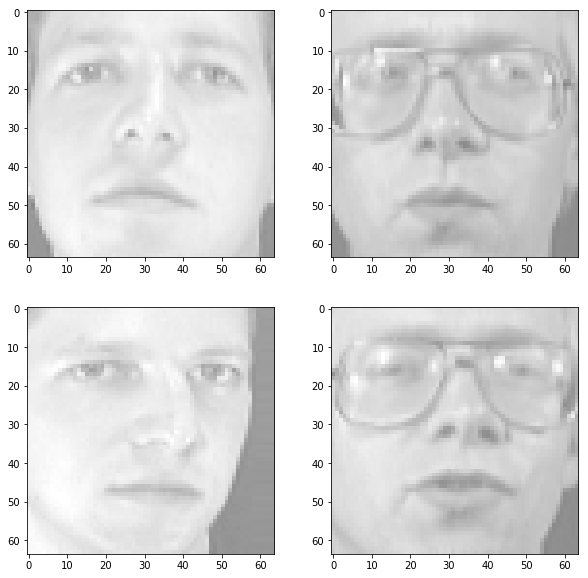

In [104]:
# we plot two sample images from the data set
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0] = plot_face(ax[0, 0], X[Y == 0][0], image_shape)
ax[0, 1] = plot_face(ax[0, 1], X[Y == 1][0], image_shape)
ax[1, 0] = plot_face(ax[1, 0], X[Y == 0][1], image_shape)
ax[1, 1] = plot_face(ax[1, 1], X[Y == 1][1], image_shape)
plt.show()

## Building an End-to-End Image Classification Model in Keras

In [111]:
# Stride size
stride_size = (2, 2)
# Pool size
pool_size = (2, 2)
# Number of filters
filters = 2
# Kernel size
kernel_size = (5, 5)

cnn_model = Sequential()
# feature extraction layer 0: convolution
cnn_model.add(Conv2D(filters, kernel_size=kernel_size, padding='same',
                     activation='tanh',
                     input_shape=(image_shape[0], image_shape[1], 1)))
# feature extraction layer 1: max pooling
cnn_model.add(MaxPooling2D(pool_size=pool_size, strides=stride_size))

# input to classification layers: flattening
cnn_model.add(Flatten())
# classification layer 0: dense non-linear transformation
cnn_model.add(Dense(10, activation='tanh'))
# classification layer 3: output label probability
cnn_model.add(Dense(1, activation='sigmoid'))


# Compile model 
cnn_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

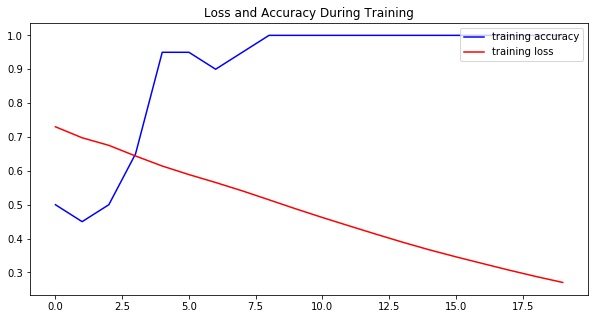

In [112]:
# Fit the model
history = cnn_model.fit(X, Y, batch_size=150, epochs=20, verbose=0)

# Plot the loss function and the evaluation metric over the course of training
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(np.array(history.history['acc']), color='blue', label='training accuracy')
ax.plot(np.array(history.history['loss']), color='red', label='training loss')
ax.set_title('Loss and Accuracy During Training')
ax.legend(loc='upper right')
plt.show()

In [113]:
# Evaluate the training and testing performance of your model 
# Note: you should check both the loss function and your evaluation metric
score = cnn_model.evaluate(X, Y, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1], '\n\n')

Train loss: 0.2541230022907257
Train accuracy: 1.0 




## What does the CNN learn?

We can visualize the filters to see if they have an "obvious" function (e.g. edge detection).

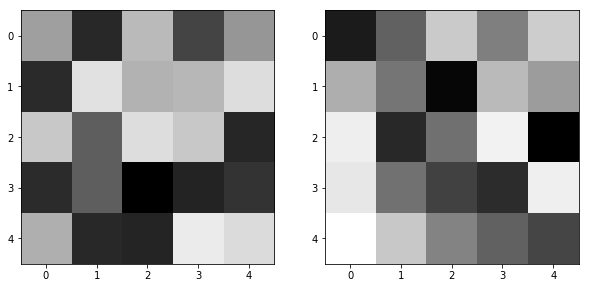

In [122]:
# we visualize the two filters we learned
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0] = plot_face(ax[0], cnn_model.layers[0].get_weights()[0][:, :, :, 0].flatten(), kernel_size)
ax[1] = plot_face(ax[1], cnn_model.layers[0].get_weights()[0][:, :, :, 1].flatten(), kernel_size)
plt.show()

In [126]:
# get the class probabilities predicted by our MLP on the training set
Y_train_pred = cnn_model.predict(X)
Y_train_pred = Y_train_pred.reshape((Y_train_pred.shape[0], ))
# get the activations for the last hidden layer in the network
last_hidden_layer = 0
latent_representation = K.function([cnn_model.input, K.learning_phase()], [cnn_model.layers[0].output])
activations = latent_representation([X, 1.])[0]

We can also visualize the result of passing images through the filters.

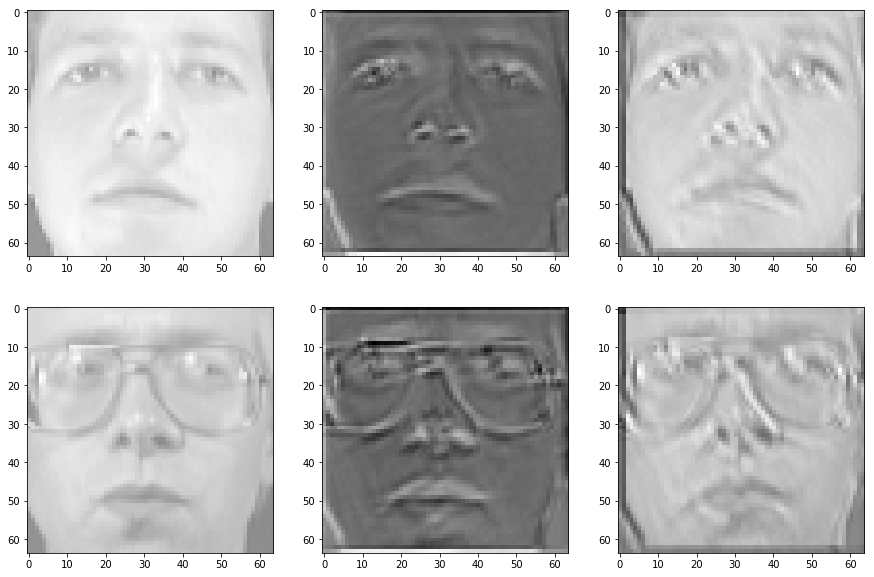

In [134]:
# visualize a training image after it passes through each filter
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0] = plot_face(ax[0, 0], X[Y == 0][0], image_shape)
ax[0, 1] = plot_face(ax[0, 1], activations[Y == 0][0][:, :, 0], image_shape)
ax[0, 2] = plot_face(ax[0, 2], activations[Y == 0][0][:, :, 1], image_shape)
ax[1, 0] = plot_face(ax[1, 0], X[Y == 1][0], image_shape)
ax[1, 1] = plot_face(ax[1, 1], activations[Y == 1][0][:, :, 0], image_shape)
ax[1, 2] = plot_face(ax[1, 2], activations[Y == 1][0][:, :, 1], image_shape)
plt.show()

## Using Pre-Trained CNNs with Any Classifier

You can use a number of pretrained CNNs for feature extraction (https://keras.io/applications/), and then use these features as input for any classifier (e.g. random forest, decision tree, MLP).


## III. Class Imbalance

## Data stratification

When the classes in your data set are extremely unbalanced, a random split of your data into training, validation and test may result in one of these sets containing **zero** instances of the rare class.

**Problem:** Training on only data containing no rare labels will result in a classifier that is unable to generalize and predict well on data with these labels that may be present in test set.


***Stratification*** is the technique to allocate the samples evenly based on sample classes so that training set and validation set have similar ratio of classes.

## Reweighting classes
When classes in your data set are extremely unbalanced, the models you train can be unincentivized to predict correctly on the rare class -- specializing on the overrepresented classes will result in low average loss. 

We can ***reweight*** the terms in the loss function so that contributions from terms associated with the rare class is increased while the contribution of those associated with the overrepresented classes is decreased. Intuitively, the model is penalized more for being 'wrong' on the rare class.

<img src="./fig/unbalanced.png" style="width: 500px;" align="center"/>

## Resampling points

We can also create a subset of the data that has a more balanced representation of all classes by: 

1. Down-sampling (Under sampling) the majority class
2. Up-sampling (Over sampling) the minority class
3. Fanciers sampling techniques

<img src="./fig/sampling.png" style="width: 500px;" align="center"/>


# III. Bias vs Variance Trade-off

## Overfitting
Complex models have ***low bias*** -- they can model a wide range of functions, given enough samples.

But complex models can use their 'extra' capacity to explain non-meaningful features of the training data that are unlikely to appear in the test data (i.e. noise). These models have ***high variance*** -- they are very sensitive to small changes in the data distribution, leading to drastic performance decrease from train to test settings.

<img src="./fig/nn_fit.png" style="width: 300px;" align="center"/>
<img src="./fig/poly_fit.png" style="width: 300px;" align="center"/>


## Regularization
A way to prevent overfitting is to reduce the capacity of the model, thereby limiting the kinds of functions they can model. This **increases bias, but reduces variance**:
1. **$\ell_1$, $\ell_2$ weight regularization** - adding a term to the loss function that penalizes the $\ell_1$-norm (sum of absolute values) or the $\ell_2$-norm (sum of squares) of the weights. This prevents the network from learning extremely squiggly functions.
``` python
from keras import regularizers
model.add(Dense(64, input_dim=64,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
```

2. **Dropout** - randomly zeroing out weights during training. This prevents the hidden nodes from "over specializing" or "memorizing" certain data points.
``` python
from keras.layers import Dropout,
model.add(Dense(64, activation='relu', input_dim=20))
model.add(Dropout(0.5))
```


## Bagging
Another way to prevent overfitting is to create ***ensembles*** of models. ***Bagging*** (Bootstrapping and Aggregating) is an ensemble method that:
1. trains a diverse set of complex models on various subsets of the training data -- low bias but high variance
2. reduces the variance by averaging the outputs of these models -- random mistakes will 'cancel out' in the average


<img src="./fig/bagging.jpg" style="width: 300px;" align="center"/>

## Boosting

***Boosting*** is an ensemble method that builds a complex model iteratively by summing together simple models:
1. train a simple model -- high bias but low variance
2. train a simple model to focus on the *errors* of the current model, add the new model to the existing model
3. repeat

***Gradient boosting*** is easy to implement by hand.

***Adaboost*** (Adaptive boosting) is implemented by `sklearn`, and can be made to work with neural network models implemented in `keras`